In [1]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
grid_size = 30

balances = np.linspace(0, 1, grid_size + 2)[1:-1]
distr_distances = np.linspace(0, 5, grid_size)
metrics = ["acc", "auc"]

In [3]:
def sample_data(mean, std=1, n=1000):
    return np.random.normal(mean, std, size=(n,))

def get_dataset(balance=0.5, mean_distance=2, n_samples=10000, test_size=0.2):
    assert 0 < balance < 1, "balance should be between 0 and 1"
    n1 = int(n_samples * balance)
    n2 = int(n_samples * (1 - balance))
    # make sure we end up at n_samples samples
    n2 += n_samples - n1 - n2
    
    x1 = sample_data(0, n=n1)
    x2 = sample_data(mean_distance, n=n2)
    
    x = np.concatenate([x1, x2])[:,None]
    y = np.concatenate([np.zeros(x1.shape[0]), np.ones(x2.shape[0])])
    return train_test_split(x, y, test_size=test_size)

def evaluate(clf, x, y, metric):
    if metric == "acc":
        return clf.score(x, y)
    elif metric == "auc":
        return roc_auc_score(y, clf.predict_proba(x)[:,1])
    else:
        raise ValueError(f"unknown metric {metric}")

In [4]:
metrics_train, metrics_test = {metric: [] for metric in metrics}, {metric: [] for metric in metrics}
for distr_dist in tqdm(distr_distances):
    for metric in metrics:
        metrics_train[metric].append([])
        metrics_test[metric].append([])
    for balance in balances:
        x_train, x_test, y_train, y_test = get_dataset(balance=balance, mean_distance=distr_dist)

        clf = LogisticRegression()
        clf.fit(x_train, y_train)

        for metric in metrics:
            metrics_train[metric][-1].append(evaluate(clf, x_train, y_train, metric))
            metrics_test[metric][-1].append(evaluate(clf, x_test, y_test, metric))

100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


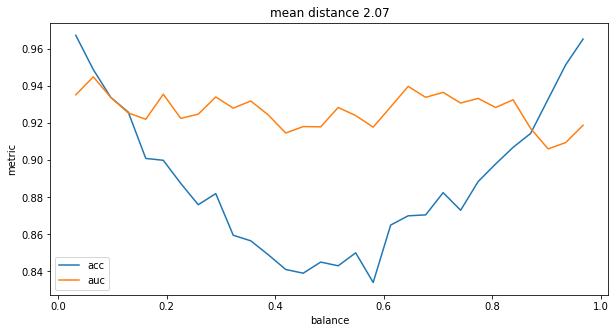

In [5]:
%matplotlib inline

dist_idx = np.argmin(np.abs(distr_distances - 2))
plt.figure(figsize=(10, 5))
plt.title(f"mean distance {distr_distances[dist_idx]:.2f}")
for metric in metrics:
    plt.plot(balances, metrics_test[metric][dist_idx], label=metric)
plt.xlabel("balance")
plt.ylabel("metric")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


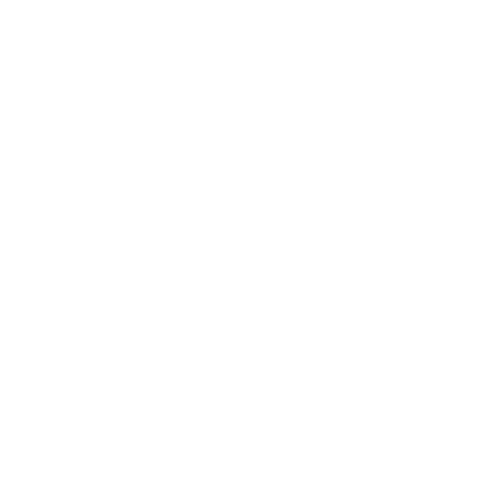

<IPython.core.display.Javascript object>


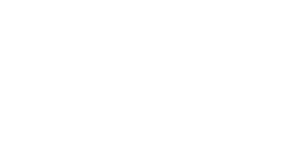

In [6]:
%matplotlib notebook

xs, ys = np.meshgrid(distr_distances, balances)
zs = {metric: np.array(dat).T for metric, dat in metrics_test.items()}

plt.figure(figsize=(7, 7))
ax = plt.subplot(projection="3d")

legend_handles = []
for i, metric in enumerate(metrics):
    color = f"C{i}"
    ax.plot_surface(xs, ys, zs[metric], color=color)
    legend_handles.append(Line2D([0], [0], linestyle="none", marker="o", color=color, label=metric))

ax.set_xlabel("mean distance")
ax.set_ylabel("balance")
ax.set_zlabel("metric")

plt.legend(handles=legend_handles)
plt.show()